# Generating SQL for SQLite using Ollama, ChromaDB
This notebook runs through the process of using the `vanna` Python package to generate SQL using AI (RAG + LLMs) including connecting to a database and training. If you're not ready to train on your own database, you can still try it using a sample [SQLite database](app.md).

## Setup

In [1]:
from vanna.utils import snake_case

In [2]:
import warnings
import re

warnings.filterwarnings('ignore', category=DeprecationWarning, message='^Number of requested results')
# warnings.filterwarnings('ignore', category=DeprecationWarning, message=re.escape(r'^Some regex pattern'))

import os

import re
from time import time
from datetime import datetime 

from vanna.ollama import Ollama
from vanna.chromadb.chromadb_vector import ChromaDB_VectorStore

In [3]:
model_name = 'deepseek-r1' # 'deepseek-coder-v2' # "codegeex4" # "llama3" # "qwen2.5" # 
CONFIG = {
    'model': model_name,   
}

file_db = "~/Downloads/datasets/chinook.db"


clean_and_train = True  # False  

sql_id = 1

allow_llm_to_see_data = True
# allow_llm_to_see_data (bool): Whether to allow the LLM to see the data (for the purposes of introspecting the data to generate the final SQL).

In [4]:
snake_case(model_name)

'deepseek_r1'

In [5]:
class MyVanna(ChromaDB_VectorStore, Ollama):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        Ollama.__init__(self, config=config)

In [6]:
vn = MyVanna(config=CONFIG)

In [7]:
hostname = os.uname().nodename
print("Hostname:", hostname)

Hostname: papa-game


In [8]:
file_db = os.path.abspath(os.path.expanduser(file_db))
vn.connect_to_sqlite(file_db)

In [9]:
vn.run_sql_is_set

True

In [10]:
if clean_and_train:
    vn.remove_collection()

In [11]:
vn.dataset

'default'

## Training

### [SQLite sample database](https://www.sqlitetutorial.net/sqlite-sample-database/)

You only need to train once. Do not train again unless you want to add more training data.

In [12]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

In [13]:
df_ddl

,type,sql
0,table,"CREATE TABLE ""albums""\r\n(\r\n [AlbumId] IN..."
1,table,"CREATE TABLE sqlite_sequence(name,seq)"
2,table,"CREATE TABLE ""artists""\r\n(\r\n [ArtistId] ..."
3,table,"CREATE TABLE ""customers""\r\n(\r\n [Customer..."
4,table,"CREATE TABLE ""employees""\r\n(\r\n [Employee..."
5,table,"CREATE TABLE ""genres""\r\n(\r\n [GenreId] IN..."
6,table,"CREATE TABLE ""invoices""\r\n(\r\n [InvoiceId..."
7,table,"CREATE TABLE ""invoice_items""\r\n(\r\n [Invo..."
8,table,"CREATE TABLE ""media_types""\r\n(\r\n [MediaT..."
9,table,"CREATE TABLE ""playlists""\r\n(\r\n [Playlist..."


In [14]:
if clean_and_train:
    for ddl in df_ddl['sql'].to_list():
        # ddl = strip_brackets(ddl)
        vn.train(ddl=ddl)

    # Sometimes you may want to add documentation about your business terminology or definitions.
    vn.train(documentation="In the chinook database invoice means order")

    doc_str = """
    In the 'customers' table, address column names do not have 'Billing' prefix, 
    e.g. country column name is 'country', not 'BillingCountry'
    """
    vn.train(documentation=doc_str)




Adding ddl: CREATE TABLE "albums"
(
    [AlbumId] INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    [Title] NVARCHAR(160)  NOT NULL,
    [ArtistId] INTEGER  NOT NULL,
    FOREIGN KEY ([ArtistId]) REFERENCES "artists" ([ArtistId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)


Adding ddl: CREATE TABLE sqlite_sequence(name,seq)


Adding ddl: CREATE TABLE "artists"
(
    [ArtistId] INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    [Name] NVARCHAR(120)
)


Adding ddl: CREATE TABLE "customers"
(
    [CustomerId] INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    [FirstName] NVARCHAR(40)  NOT NULL,
    [LastName] NVARCHAR(20)  NOT NULL,
    [Company] NVARCHAR(80),
    [Address] NVARCHAR(70),
    [City] NVARCHAR(40),
    [State] NVARCHAR(40),
    [Country] NVARCHAR(40),
    [PostalCode] NVARCHAR(10),
    [Phone] NVARCHAR(24),
    [Fax] NVARCHAR(24),
    [Email] NVARCHAR(60)  NOT NULL,
    [SupportRepId] INTEGER,
    FOREIGN KEY ([SupportRepId]) REFERENCES "employees" ([EmployeeId]) 
		ON DELETE NO

In [15]:
# show training data
training_data = vn.get_training_data()
training_data

,id,dataset,question,content,training_data_type
0,020848a7-bac7-53cf-9af9-ca0f8e540216-ddl,default,None,"CREATE INDEX IFK_EmployeeReportsTo ON ""employe...",ddl
1,02ee8d00-a7dd-5598-b62b-e3a06084dbda-ddl,default,None,"CREATE TABLE ""playlists""\r\n(\r\n PlaylistI...",ddl
2,039a70d7-499f-57e5-9cff-73e7c23dd2b3-ddl,default,None,"CREATE TABLE ""media_types""\r\n(\r\n MediaTy...",ddl
3,0f11423b-66c8-5ba4-8e59-2e4f617db70e-ddl,default,None,"CREATE TABLE ""invoices""\r\n(\r\n InvoiceId ...",ddl
4,1323a585-b921-528b-a12c-54697d3801d3-ddl,default,None,"CREATE TABLE ""employees""\r\n(\r\n EmployeeI...",ddl
5,1b4e1e26-6cfa-573b-94b7-055aa1257b40-ddl,default,None,"CREATE INDEX IFK_CustomerSupportRepId ON ""cust...",ddl
6,24ecfae0-fd59-599e-b6a0-b3ac0fa44dd1-doc,default,None,"\n In the 'customers' table, address column...",documentation
7,29a795c2-f536-548c-85b1-494e94c547c4-ddl,default,None,"CREATE TABLE ""albums""\r\n(\r\n AlbumId INTE...",ddl
8,38197d19-a90b-5ebe-b51d-eeee8760b334-ddl,default,None,"CREATE TABLE ""playlist_track""\r\n(\r\n Play...",ddl
9,4bbdce6c-4cbd-53a7-98d6-455b65c23f1c-ddl,default,None,"CREATE INDEX IFK_TrackAlbumId ON ""tracks"" (Alb...",ddl


## Asking the AI
Whenever you ask a new question, it will find the 10 most relevant pieces of training data and use it as part of the LLM prompt to generate the SQL.

### warm-up





# QUESTION :  How many customers are there



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT COUNT(CustomerId) AS NumberOfCustomers 
FROM "customers";


[( <SQL> )]
generated SQL statement



SELECT COUNT(CustomerId) AS NumberOfCustomers 
FROM "customers";


[( <DataFrame> )]
queried dataframe



,NumberOfCustomers
0,59



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



<think>
Okay, so I need to help the user generate Plotly code to chart their DataFrame. The user's question was about how many customers there are, and they provided some information about the resulting pandas DataFrame.

First, looking at the query they used: SELECT COUNT(CustomerId) AS NumberOfCustomers FROM "customers" LIMIT 20. That tells me that the DataFrame 'df' has a column called 'NumberOfCustomers', which is an integer because it's counting something. The user also mentioned that when they ran df.dtypes, the data type was int64.

Now, the task is to create a Plotly chart from this DataFrame. Let me break down what needs to be done:

1. **Chart Type**: Since the query counts the number of customers, it's likely just one value. But the user wants to use an Indicator if there's only one value. However, in their example response, they used a bar chart regardless. Maybe because even with one value, a bar chart can still represent it. Alternatively, perhaps using a pie chart or another type would be better for a single data point.

2. **Data Limitation**: The user mentioned that if the DataFrame has more than 20 rows, use df.head(20). But in this case, since they're counting and getting just one value (NumberOfCustomers), it's probably only one row. So using head might not be necessary here, but to follow the instruction, I should include it.

3. **Indicator for Single Value**: The user specified that if there's only one value, use an Indicator. But in their example code, they used a bar chart. Maybe they meant to use a different type of chart when there's only one value. However, since the query returns a single integer count, perhaps it's better represented as a simple bar or even a pie chart.

4. **Plotly Setup**: I need to import Plotly Express because it's straightforward for creating charts. Then, create a figure using px.bar or another appropriate function.

Putting this together, if there's only one value, the code should use an Indicator. But since in their example they used a bar chart regardless, perhaps the condition is not strictly applied here. Alternatively, maybe the user wants to handle both cases: when there's more than one row and when there's just one.

Wait, but looking at the query again, it's selecting COUNT(CustomerId), which would return a single integer value

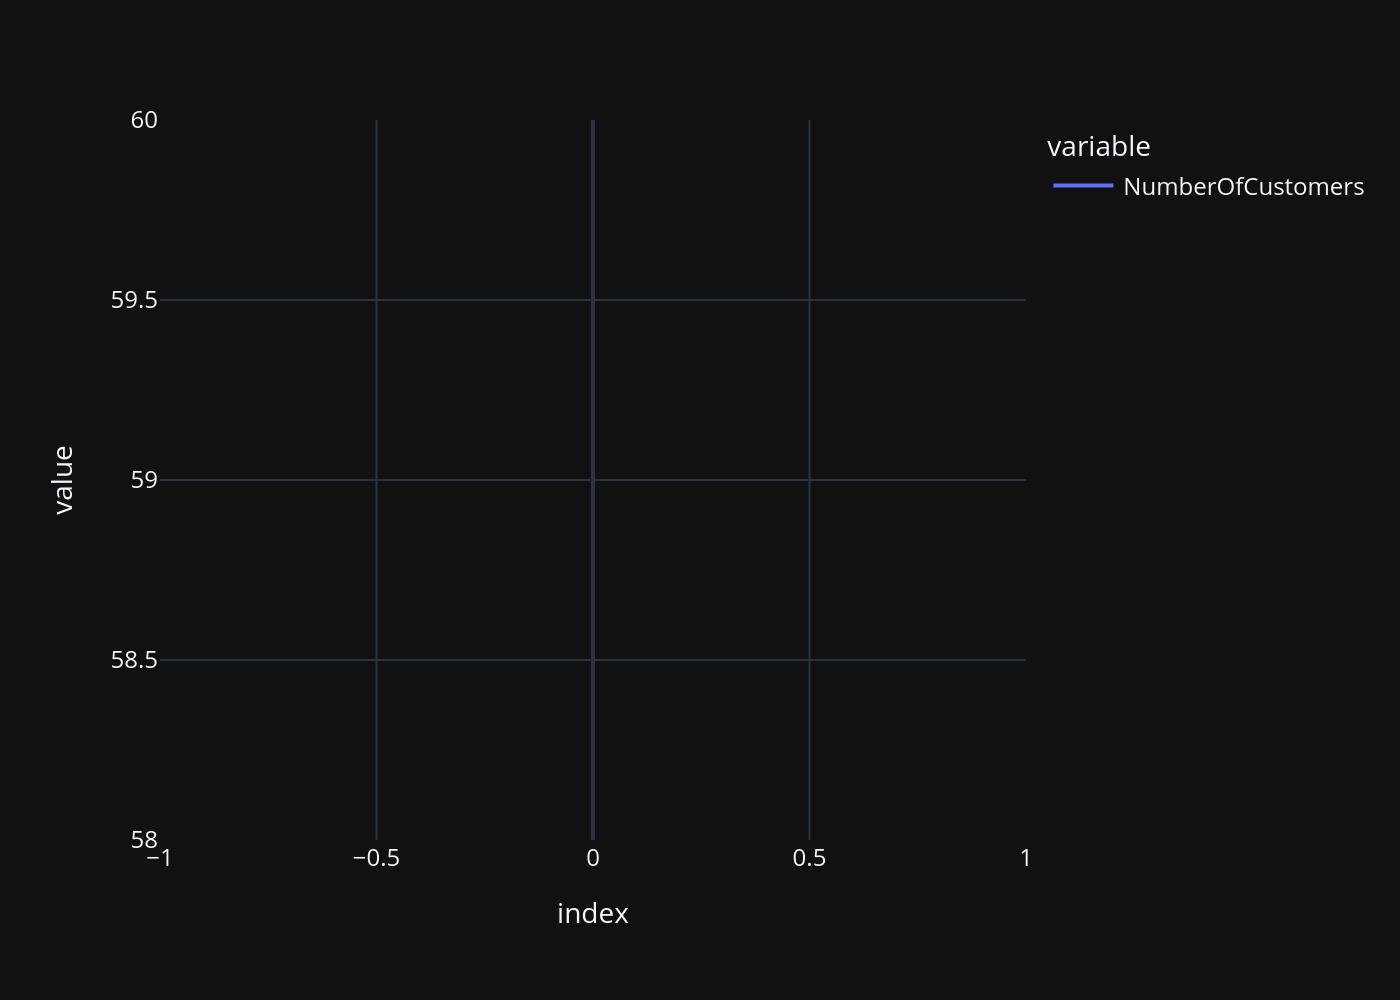

elapsed_time = 28.099133253097534


In [16]:
ts_start = time()
question = "How many customers are there"
resp = vn.ask_adaptive(question=question)
ts_stop = time()
elapsed_time = ts_stop - ts_start
print(f"elapsed_time = {elapsed_time}")

```sql

SELECT name FROM sqlite_master WHERE type = 'table';

```

```sql

SELECT c.CustomerId, SUM(il.Quantity) AS TotalAlbums
FROM Customers c
JOIN invoices i  ON c.CustomerId = i.CustomerId
JOIN invoice_items il ON i.InvoiceId = il.InvoiceId
GROUP BY c.CustomerId
ORDER BY TotalAlbums DESC
LIMIT 5

```


In [17]:
questions = [
    "Can you list all tables in the SQLite database catalog?",
    "which table stores customer's orders",
    "How many customers are there",
    "what are the top 5 countries that customers come from?",
    "List all albums and their corresponding artist names  ",
    """Find all tracks with a name containing "What" (case-insensitive) """,
    "Get the total number of invoices for each customer",
    "Find the total number of invoices per country",
    "List all invoices with a total exceeding $10",
    "Find all invoices since 2010 and the total amount invoiced:",
    "List all employees and their reporting manager's name (if any):",
    " Get the average invoice total for each customer:",
    "Find the top 5 most expensive tracks (based on unit price):",
    "List all genres and the number of tracks in each genre:",
    "Get all genres that do not have any tracks associated with them:",
    "List all customers who have not placed any orders:",
    """ 
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    """,
    "List all customers from Canada and their email addresses:",
    "Find the customer with the most invoices ",
    "Find the customer who bought the most albums in total quantity (across all invoices):",
    """      
        Find the top 5 customers who bought the most albums in total quantity (across all invoices):
        Hint: album quantity is found in invoice_items, 
    """,
    """  
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    """,
    "Get all playlists containing at least 10 tracks and the total duration of those tracks:",
    "Identify artists who have albums with tracks appearing in multiple genres:",
]

### Loop over questions





# QUESTION  - 2:  Can you list all tables in the SQLite database catalog?



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT name 
FROM sqlite_master 
WHERE type = 'table';


[( <SQL> )]
generated SQL statement



SELECT name 
FROM sqlite_master 
WHERE type = 'table';


[( <DataFrame> )]
queried dataframe



,name
0,albums
1,sqlite_sequence
2,artists
3,customers
4,employees
5,genres
6,invoices
7,invoice_items
8,media_types
9,playlists



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



<think>
Okay, so I need to help the user generate Python Plotly code based on their query and DataFrame information. Let me break this down step by step.

First, the user is asking about listing all tables in an SQLite database using a pandas DataFrame. They provided that the DataFrame 'df' was created with a specific SQL query: SELECT name FROM sqlite_master WHERE type = 'table' LIMIT 20. So, the DataFrame contains just the table names, limited to 20 rows.

The user now wants a Plotly chart from this DataFrame. The instructions mention two conditions: if the dataframe has more than 20 rows, use df.head(20), but in their case, since they already limited it to 20, maybe that's just for generality. Also, if there's only one value, use an Indicator.

Looking at the DataFrame 'df', each row is a table name, so using a bar chart makes sense because we're comparing different categories (table names). Since all values are strings, a bar chart will display each table as a separate bar with its count. But since each table appears once, except maybe if there are duplicates in the data.

Wait, but in their case, 'df' is from LIMIT 20, so it's possible that they have up to 20 tables. So using Plotly to visualize this would show each table as a bar with height 1, which might not be very informative visually. But since the user wants code, I'll proceed.

The user also mentioned if there's only one value, use an Indicator. But in their case, 'df' has multiple values (up to 20), so that condition doesn't apply here. So, we can skip using an Indicator and go with a bar chart.

Now, the code structure: I'll need to import Plotly Express because it's straightforward for creating charts quickly. Then, create a Figure object, use px.bar to make the bar plot, passing 'df' as the data. Since each table is unique in their sample, but if there are duplicates, they might stack or group by another parameter.

But wait, what if some tables have the same name? The SQL query returns distinct names, so maybe that's not an issue here. So, I'll just proceed with a simple bar chart where each bar represents one table.

Putting it all together, the code will import Plotly Express, create a Figure

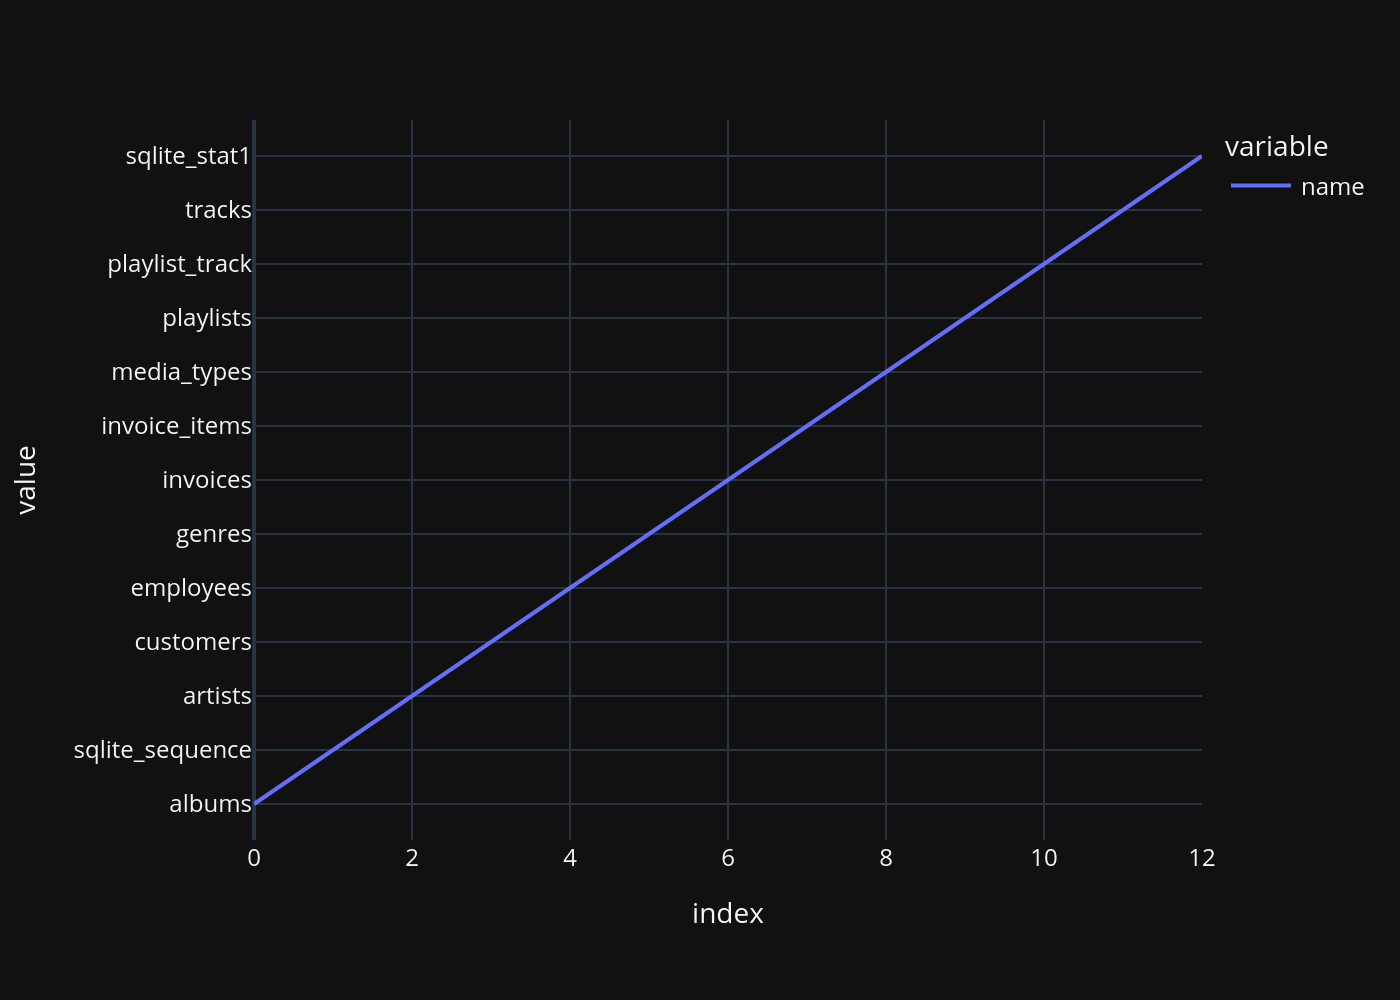





# QUESTION  - 3:  which table stores customer's orders



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, '

SELECT * FROM invoices;


[( <DataFrame> )]
queried dataframe



,InvoiceId,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total
0,1,2,2009-01-01 00:00:00,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,1.98
1,2,4,2009-01-02 00:00:00,Ullevålsveien 14,Oslo,None,Norway,0171,3.96
2,3,8,2009-01-03 00:00:00,Grétrystraat 63,Brussels,None,Belgium,1000,5.94
3,4,14,2009-01-06 00:00:00,8210 111 ST NW,Edmonton,AB,Canada,T6G 2C7,8.91
4,5,23,2009-01-11 00:00:00,69 Salem Street,Boston,MA,USA,2113,13.86
5,6,37,2009-01-19 00:00:00,Berger Straße 10,Frankfurt,None,Germany,60316,0.99
6,7,38,2009-02-01 00:00:00,Barbarossastraße 19,Berlin,None,Germany,10779,1.98
7,8,40,2009-02-01 00:00:00,"8, Rue Hanovre",Paris,None,France,75002,1.98
8,9,42,2009-02-02 00:00:00,"9, Place Louis Barthou",Bordeaux,None,France,33000,3.96
9,10,46,2009-02-03 00:00:00,3 Chatham Street,Dublin,Dublin,Ireland,None,5.94



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



<think>
Alright, so I need to figure out which table stores customer's orders in this SQLite database setup. Let me start by looking through the provided context.

First, I see that there are several tables defined: invoices, customers, invoice_items, employees, playlist_track, tracks, albums, playlists, and some system tables like sqlite_sequence and tracks.

I know that in many databases, customer orders are typically stored in a separate table, often named something like "orders" or similar. But looking at the given tables, I don't see an "orders" table listed here.

Next, I notice there's a table called "invoices". In this context, it's mentioned that "invoices" might be related to orders since invoices are essentially purchase orders from suppliers but can also represent customer transactions if set up that way. However, the documentation clarifies that in this database, "invoices" refers to orders from customers.

To confirm, I check the schema of the "invoices" table: it has fields like InvoiceId, CustomerId, InvoiceDate, BillingAddress, etc., which are typical for tracking customer transactions and their details. This suggests that "invoices" is indeed storing information about customer orders.

Therefore, based on this analysis, the table that stores customer's orders is the "invoices" table.
</think>

The table that stores customer's orders in this SQLite database setup is:

**"invoices"**

This table contains information related to customer transactions, including details like InvoiceId, CustomerId, InvoiceDate, and other relevant fields.

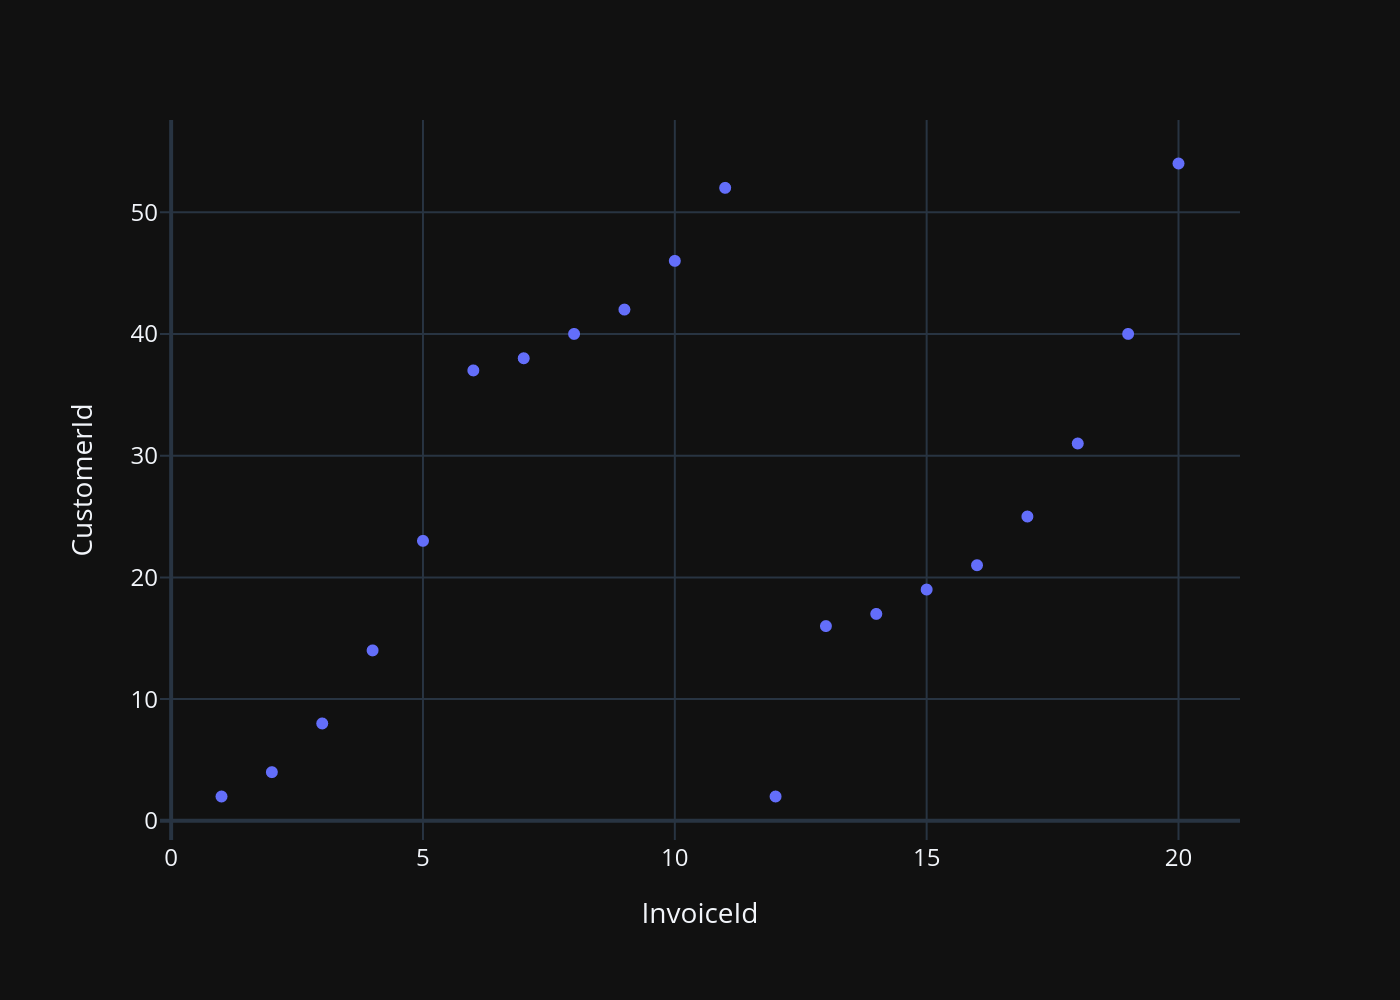





# QUESTION  - 4:  How many customers are there



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT COUNT(DISTINCT CustomerId) AS TotalCustomers FROM Customers;


[( <SQL> )]
generated SQL statement



SELECT COUNT(DISTINCT CustomerId) AS TotalCustomers FROM Customers;


[( <DataFrame> )]
queried dataframe



,TotalCustomers
0,59



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px-indicator(value=df.TotalCustomers[0])
else:
    fig = px.bar(df.head(20), x=df.index, y='TotalCustomers')

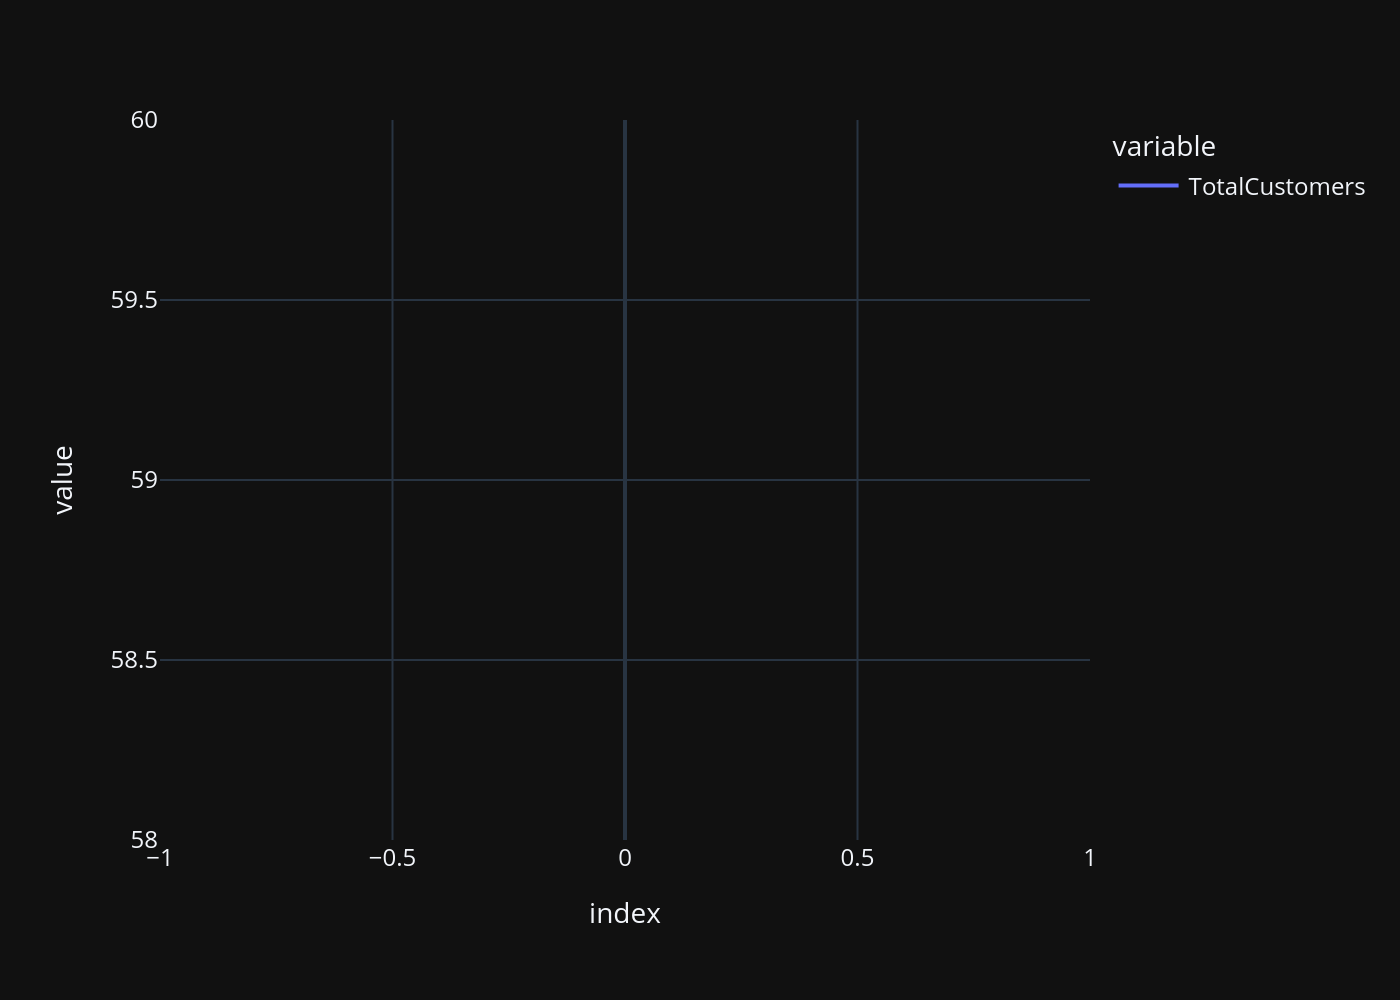





# QUESTION  - 5:  what are the top 5 countries that customers come from?



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT 
    DISTINCT o.BillingCountry AS Country,
    COUNT(*) AS CustomerCount
FROM 
    invoices AS o
JOIN 
    customers ON o.CustomerId = customers.CustomerId
GROUP BY 
    Country;
ORDER BY 
    CustomerCount DESC;


[( <SQL> )]
generated SQL statement



SELECT 
    DISTINCT o.BillingCountry AS Country,
    COUNT(*) AS CustomerCount
FROM 
    invoices AS o
JOIN 
    customers ON o.CustomerId = customers.CustomerId
GROUP BY 
    Country;
ORDER BY 
    CustomerCount DESC;


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT
    o.BillingCountry AS Country,
    COUNT(*) AS Count
FROM
    invoices AS o
JOIN
    customers AS c ON o.CustomerId = c.CustomerId
GROUP BY
    Country
ORDER BY
    Count DESC;
```

This should give me a list of countries with their respective counts, sorted by frequency.

I think this makes sense. I'll run this query to see the results.
</think>

To determine which countries customers are from using the provided SQL database, we can leverage the relationship betw

SELECT
    o.BillingCountry AS Country,
    COUNT(*) AS Count
FROM
    invoices AS o
JOIN
    customers AS c ON o.CustomerId = c.CustomerId
GROUP BY
    Country
ORDER BY
    Count DESC;
```

This should give me a list of countries with their respective counts, sorted by frequency.

I think this makes sense. I'll run this query to see the results.
</think>

To determine which countries customers are from using the provided SQL database, we can leverage the relationship between the "customers" and "invoices" tables. Here's how:

1. **Identify Relevant Tables**: The "customers" table contains customer data, including CustomerId, while the "invoices" table includes BillingCountry.
2. **Understand Data Relationships**: Each invoice's BillingCountry corresponds to the customer's country associated with that invoice.
3. **Formulate the Join**: By joining these tables on CustomerId, we can associate each invoice's country with its respective customer.

Here is the SQL query:





# QUESTION  - 6:  List all albums and their corresponding artist names  



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None



KeyboardInterrupt: 

In [18]:
ts_start = time()
for n, question in enumerate(questions):
    # if n != 4: continue
    if n > 5: continue

    resp = vn.ask_adaptive(question=question, tag_id=n+2)
    # vn.ask(question=question, allow_llm_to_see_data=allow_llm_to_see_data)
    # my_vn_ask(question=question, sql_id=n+2, allow_llm_to_see_data=allow_llm_to_see_data)

ts_stop = time()
elapsed_time = ts_stop - ts_start

### Check completion time

In [17]:
str_elapsed_sec = f"{elapsed_time:.0f}"
ts = datetime.now().strftime("%Y%m%d-%H%M%S")
print(f"Completed testing:\n================\n LLM model '{model_name}' \n took {str_elapsed_sec} sec\n run on '{hostname}' \n at {ts}")

Completed testing:
 LLM model 'deepseek-r1' 
 took 1072 sec
 run on 'ducklover1' 
 at 20250127-090750


In [18]:
file_csv = f"training_data-{model_name}-{str_elapsed_sec}s-{hostname}-{ts}.csv"
file_csv

'training_data-deepseek-r1-1072s-ducklover1-20250127-090750.csv'

### Save training data

In [19]:
# show training data
df_training_data = vn.get_training_data()
df_training_data

,id,dataset,question,content,training_data_type
0,020848a7-bac7-53cf-9af9-ca0f8e540216-ddl,default,None,"CREATE INDEX IFK_EmployeeReportsTo ON ""employe...",ddl
1,02ee8d00-a7dd-5598-b62b-e3a06084dbda-ddl,default,None,"CREATE TABLE ""playlists""\r\n(\r\n PlaylistI...",ddl
2,039a70d7-499f-57e5-9cff-73e7c23dd2b3-ddl,default,None,"CREATE TABLE ""media_types""\r\n(\r\n MediaTy...",ddl
3,0f11423b-66c8-5ba4-8e59-2e4f617db70e-ddl,default,None,"CREATE TABLE ""invoices""\r\n(\r\n InvoiceId ...",ddl
4,1323a585-b921-528b-a12c-54697d3801d3-ddl,default,None,"CREATE TABLE ""employees""\r\n(\r\n EmployeeI...",ddl
5,145e4a83-6108-5890-84b7-9062ff9e661e-sql,default,\n Generating SQL for this ...,"SELECT InvoiceId, CustomerId, Total FROM ""invo...",sql
6,1b4e1e26-6cfa-573b-94b7-055aa1257b40-ddl,default,None,"CREATE INDEX IFK_CustomerSupportRepId ON ""cust...",ddl
7,24ecfae0-fd59-599e-b6a0-b3ac0fa44dd1-doc,default,None,"\n In the 'customers' table, address column...",documentation
8,29a795c2-f536-548c-85b1-494e94c547c4-ddl,default,None,"CREATE TABLE ""albums""\r\n(\r\n AlbumId INTE...",ddl
9,38197d19-a90b-5ebe-b51d-eeee8760b334-ddl,default,None,"CREATE TABLE ""playlist_track""\r\n(\r\n Play...",ddl


In [20]:
df_training_data.to_csv(file_csv, index=False)

In [23]:
from vanna.utils import snake_case
model_name = "deepseek-r1:1.5b"
snake_case(model_name)

'deepseek_r1_1_5b'